In [2]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os

In [12]:
#to extract the images from the directory i.e to get the whole data with img_size 28 to train our model
labels = ['COVID','NORMAL','Viral Pneumonia']
img_size = 28
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [13]:
#getting the overall data
df = get_training_data('../content/COVID-19 Radiography Database')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [14]:
#to extract the images from the directory i.e to get the whole data with img_size 150 to visualise the images 
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [15]:
#getting the overall data
df1 = get_training_data('../content/COVID-19 Radiography Database')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [16]:
df[2500][1]

1

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


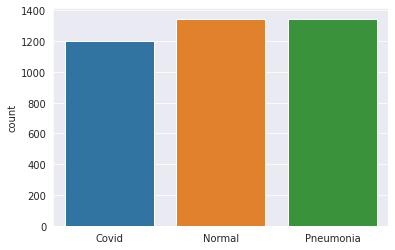

In [17]:
#A countplot/crosstab to represent the number of radiology reports in each of the categories.
l = []
for i in df:
    if(i[1] == 0):
        l.append("Covid")
    elif(i[1] == 1):
        l.append("Normal")    
    else:
        l.append("Pneumonia")
sns.set_style('darkgrid')
sns.countplot(l)        

In [18]:
#The dataset images look like this
df1[0][0]

array([[ 16,  17,  18, ...,  10,   8,   8],
       [  9,   3,   4, ...,   0,   0,   0],
       [  9,   0,   1, ...,   2,   1,   1],
       ...,
       [198, 198, 199, ..., 163, 156, 144],
       [218, 199, 204, ..., 159, 154, 157],
       [212, 209, 200, ..., 172, 167, 157]], dtype=uint8)

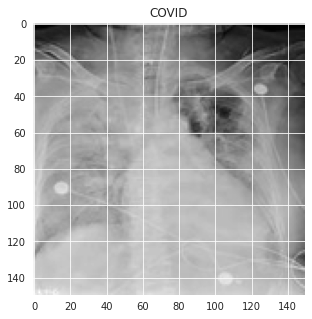

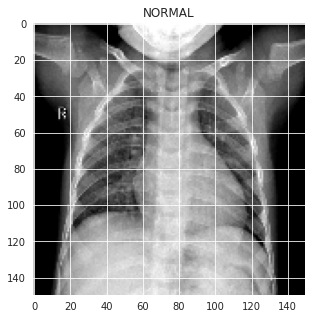

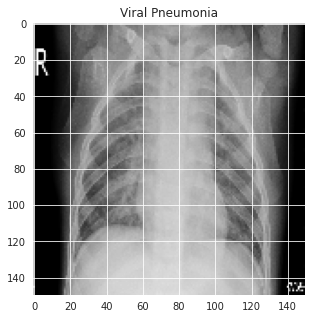

In [19]:
#plotting images for each of the categories
plt.figure(figsize = (5,5))
plt.imshow(df1[0][0], cmap='gray')
plt.title(labels[df1[0][1]])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(df1[2200][0], cmap='gray')
plt.title(labels[df1[2000][1]])
plt.show()
plt.figure(figsize = (5,5))
plt.imshow(df1[-8][0], cmap='gray')
plt.title(labels[df1[-1][1]])
plt.show()

In [21]:
#image size has been changed again since its going to be used for our model
img_size = 28
train,test= train_test_split(df,test_size=.2, random_state=0)
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [22]:
x_train.shape

(3108, 28, 28, 1)

In [23]:
y_train.shape

(3108,)

In [24]:
#building the model using Keras Tuner so taking a range of values for the layers desired to be tuned.
def build_model(hp):  
  model = keras.Sequential([
     # giving range of values for filters and kernel_size for tuning for convolutional layer                       
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    # giving range of values for stride and pool_size for tuning for pooling layer
    keras.layers.MaxPool2D(
        strides=hp.Choice('stride_1_kernel', values = [1,2,3]),
        pool_size=hp.Choice('pool_1_kernel', values = [2,3,5])
    ),
    # giving range of values for filters and kernel_size for tuning for convolutional layer 
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,5]),
        activation='relu'
    ),
    # giving range of values for stride and pool_size for tuning for pooling layer
    keras.layers.MaxPool2D(
        strides=hp.Choice('stride_2_kernel', values = [1,2,3]),
        pool_size=hp.Choice('pool_2_kernel', values = [2,3,5])
    ),
    keras.layers.Flatten(),
    # giving range of values for no. of units for tuning for dense layer 
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(3, activation='softmax')
  ])
  #model compiled using Adam's optimizer with choices for learning rate
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [25]:
#A function defined for keras tuner to look at each of the models
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='mine_dir',
    project_name='corona')

In [26]:
#function called to search the results for different combinations of the parameter values in layers
tuner_search.search(x_train,y_train,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 07s]
val_accuracy: 0.8713826537132263

Best val_accuracy So Far: 0.9035369753837585
Total elapsed time: 00h 01m 40s
INFO:tensorflow:Oracle triggered exit


In [27]:
#to get the best model parameters
model=tuner_search.get_best_models(num_models=1)[0]

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 80)        2080      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 80)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 48)        15408     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1728)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                110656    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [29]:
import time
t1=time.time()
#model training for 20 iterations
history=model.fit(x_train, y_train, epochs=20, validation_split=0.1,verbose=1)
t2=time.time()
print('The time taken to train the model is',round(int(t2-t1)/60,2),'minutes')

Epoch 1/20
88/88 [==============================] - 9s 100ms/step - loss: 0.2914 - accuracy: 0.8928 - val_loss: 0.2991 - val_accuracy: 0.8875
Epoch 2/20
88/88 [==============================] - 9s 99ms/step - loss: 0.2291 - accuracy: 0.9200 - val_loss: 0.3649 - val_accuracy: 0.8521
Epoch 3/20
88/88 [==============================] - 9s 98ms/step - loss: 0.2325 - accuracy: 0.9205 - val_loss: 0.2572 - val_accuracy: 0.9035
Epoch 4/20
88/88 [==============================] - 9s 98ms/step - loss: 0.2226 - accuracy: 0.9179 - val_loss: 0.2417 - val_accuracy: 0.9164
Epoch 5/20
88/88 [==============================] - 9s 99ms/step - loss: 0.1802 - accuracy: 0.9359 - val_loss: 0.2636 - val_accuracy: 0.9132
Epoch 6/20
88/88 [==============================] - 9s 98ms/step - loss: 0.1809 - accuracy: 0.9342 - val_loss: 0.2282 - val_accuracy: 0.9260
Epoch 7/20
88/88 [==============================] - 9s 98ms/step - loss: 0.1648 - accuracy: 0.9415 - val_loss: 0.2189 - val_accuracy: 0.9293
Epoch 8/20
8

In [35]:
#evaluation of model for test data
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

25/25 [==============================] - 0s 17ms/step - loss: 0.1324 - accuracy: 0.9486
Loss of the model is -  0.13241390883922577
25/25 [==============================] - 0s 17ms/step - loss: 0.1324 - accuracy: 0.9486
Accuracy of the model is -  94.8586106300354 %


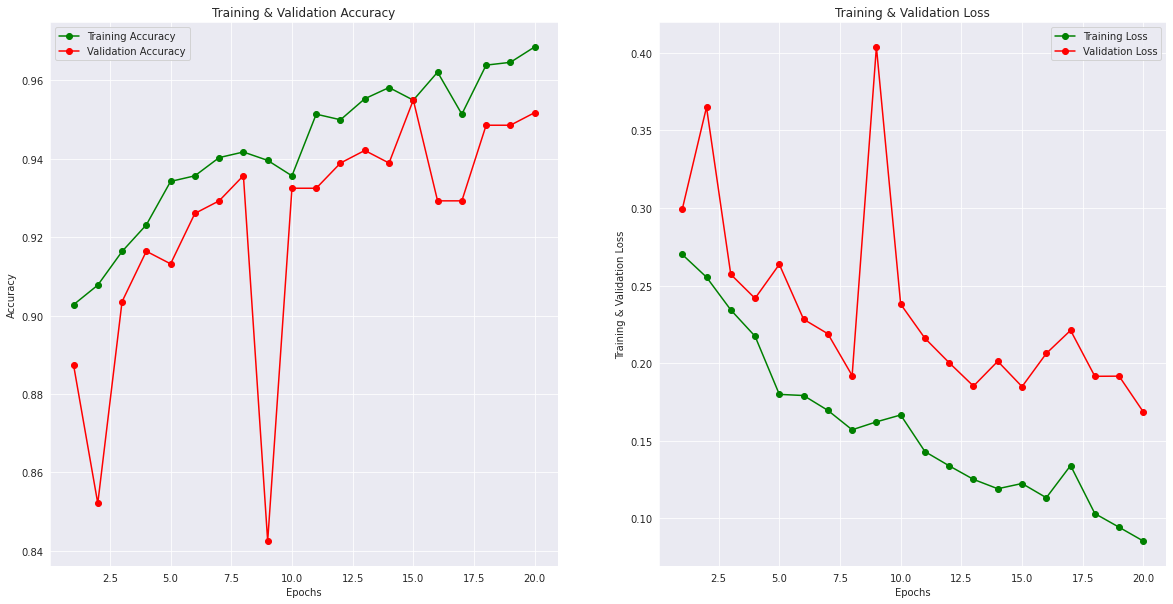

In [36]:
#plotting for loss and accuracies of training and validation set
epochs = [i for i in range(1,21)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [37]:
#class prediction for test data
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions[:15]

array([0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2])

In [38]:
#display classification report for each of the classes
print(classification_report(y_test, predictions, target_names = ['Covid (Class 0)','Normal (Class 1)','Pneumonia(Class 2)']))


                    precision    recall  f1-score   support

   Covid (Class 0)       0.98      0.96      0.97       252
  Normal (Class 1)       0.92      0.96      0.94       247
Pneumonia(Class 2)       0.95      0.93      0.94       279

          accuracy                           0.95       778
         macro avg       0.95      0.95      0.95       778
      weighted avg       0.95      0.95      0.95       778



[Text(69.0, 0.5, 'Predicted Outcome'), Text(0.5, 69.0, 'Actual Outcome')]

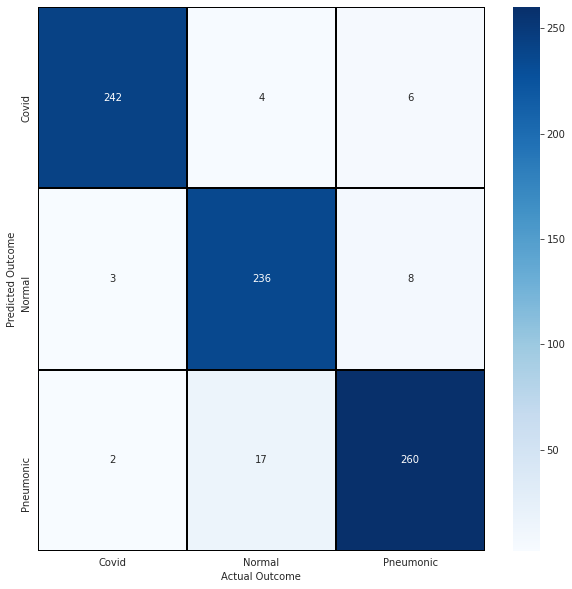

In [39]:
#to plot a confusion matrix
cm=confusion_matrix(y_test, predictions)
cm1 = pd.DataFrame(cm , index = ['Covid','Normal','Pneumonic'] , columns = ['Covid','Normal','Pneumonic'])
plt.figure(figsize = (10,10))
ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
ax.set(xlabel="Actual Outcome", ylabel = "Predicted Outcome")